Starting with some of the simpler models https://doi.org/10.1063/1.4794427

In [1]:
using QuantumDynamics
using Plots
using LinearAlgebra

In [31]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const mev2au = mev2invcm * invcm2au
const nm2au = 18.897

N=2

H0 = Matrix{ComplexF64}([
        0.0 50.0
        50.0 -75.0
    ]) * mev2au

λs = repeat([25.0], N) * mev2au
γs = repeat([150.0], N) * mev2au
JwH = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwH, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

dt = 1/au2fs 
nsteps = 150
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1.0

β = 1 / (300 * 3.16683e-6) # T = 300K

@time t_HEOM, ρs_HEOM = HEOM.propagate(;
                                    Hamiltonian=H0,
                                    ρ0,
                                    β,
                                    dt,
                                    ntimes=nsteps,
                                    Jw=JwH,
                                    sys_ops=sys_ops,
                                    num_modes=2,
                                    Lmax=3)

  5.361255 seconds (61.82 M allocations: 2.567 GiB, 6.44% gc time)


([0.0, 41.34137457575099, 82.68274915150198, 124.02412372725297, 165.36549830300396, 206.70687287875495, 248.04824745450594, 289.38962203025693, 330.7309966060079, 372.0723711817589  …  5829.1338151808895, 5870.47518975664, 5911.816564332391, 5953.157938908143, 5994.499313483893, 6035.840688059644, 6077.182062635396, 6118.523437211146, 6159.864811786897, 6201.206186362649], [1.0 + 0.0im 0.0 + 0.0im; 0.9943096624156128 + 0.0im 0.004009636212731712 - 0.07412345022595437im; … ; 0.19300179543088702 + 0.0im -0.3293151370968817 - 0.005286371818863155im; 0.1923421802657811 + 0.0im -0.32955029374016137 - 0.003395916214427217im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.004009636212731712 + 0.07412345022595437im 0.005690337584387173 + 0.0im; … ; -0.3293151370968817 + 0.005286371818863155im 0.8069982045691122 + 0.0im; -0.32955029374016137 + 0.003395916214427217im 0.8076578197342181 + 0.0im])

In [36]:
Jw = SpectralDensities.DrudeLorentz(λ=25*mev2au, γ=150*mev2au, Δs=1.0)
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)
@time t_TTM, ρ_TTM = TTM.propagate(; fbU=fbU,
                            Jw=[Jw],
                            β=β,
                            ρ0=ρ0,
                            dt=dt,
                            ntimes=nsteps,
                            rmax=10,
                            svec=[1.0 2.0],
                            extraargs=TEMPO.TEMPOArgs(),
                            path_integral_routine=TEMPO.build_augmented_propagator)

  3.559996 seconds (383.10 k allocations: 288.300 MiB, 94.59% gc time)


(0.0:41.34137457575099:6201.206186362649, [1.0 + 0.0im 0.0 + 0.0im; 0.9942462520860877 - 4.887448295820073e-19im 0.0005360122950892722 - 0.07546708900222013im; … ; 0.15457118910116763 - 1.5322801547536072e-14im -0.2951688086857329 - 0.13372947858002032im; 0.13596436033308246 - 1.642840613960058e-14im -0.28543324533402475 - 0.1154592485797661im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0005360122950892497 + 0.0754670890022201im 0.005753747913912709 + 2.4936649967166602e-18im; … ; -0.295168808685736 + 0.13372947858012926im 0.8453656084182819 - 1.24145681400155e-13im; -0.28543324533402853 + 0.11545924857987803im 0.8639719471771682 - 1.2387026690405991e-13im])

In [46]:
@time tq, ρq = QuAPI.propagate(; 
                        fbU=fbU,
                        Jw=[Jw],
                        β=β,
                        ρ0=ρ0,
                        dt,
                        ntimes=nsteps,
                        svec=[1.0 2.0],
                        kmax=7)

 22.858456 seconds (199.57 M allocations: 11.435 GiB, 44.51% gc time)


(0.0:41.34137457575099:6201.206186362649, [1.0 + 0.0im 0.0 + 0.0im; 0.9942462520860877 + 0.0im 0.0005360122950892532 - 0.07546708900222016im; … ; 0.38573739707088234 + 2.5759812873189784e-16im -0.24278297207036884 - 0.08618224483061496im; 0.3723843908293634 - 2.893060874997787e-16im -0.23601512723478046 - 0.08879216548167913im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0005360122950892532 + 0.07546708900222016im 0.005753747913912703 + 0.0im; … ; -0.24278297207036864 + 0.08618224483061118im 0.6142626029291174 + 6.329140958706204e-17im; -0.23601512723478144 + 0.08879216548167775im 0.6276156091706419 + 3.175777669155589e-16im])

In [33]:
@time t_BRME, ρs_BRME = BlochRedfield.propagate(;
                                            Hamiltonian=H0,
                                            Jw=JwH,
                                            β,
                                            ρ0,
                                            dt,
                                            ntimes=nsteps,
                                            sys_ops)

  4.471107 seconds (8.27 M allocations: 542.856 MiB, 4.69% gc time, 99.28% compilation time: <1% of which was recompilation)


([0.0, 41.34137457575099, 82.68274915150198, 124.02412372725297, 165.36549830300396, 206.70687287875495, 248.04824745450594, 289.38962203025693, 330.7309966060079, 372.0723711817589  …  5829.1338151808895, 5870.47518975664, 5911.816564332391, 5953.157938908143, 5994.499313483893, 6035.840688059644, 6077.182062635396, 6118.523437211146, 6159.864811786897, 6201.206186362649], [1.0 + 0.0im 0.0 + 0.0im; 0.9713617943727799 + 0.0im -0.002480016353649908 - 0.07323525813687778im; … ; 0.1671829209597714 - 2.2551405187698492e-17im -0.3389819390632087 + 0.011617671160955375im; 0.16923220599427707 - 3.122502256758253e-17im -0.34112567743638855 + 0.02288699095111014im;;; 0.0 + 0.0im 0.0 + 0.0im; -0.0024800163536499165 + 0.07323525813687778im 0.02863820562722015 + 0.0im; … ; -0.3389819390632088 - 0.01161767116095534im 0.8328170790402285 + 2.168404344971009e-17im; -0.34112567743638866 - 0.022886990951110093im 0.8307677940057226 + 3.2959746043559335e-17im])

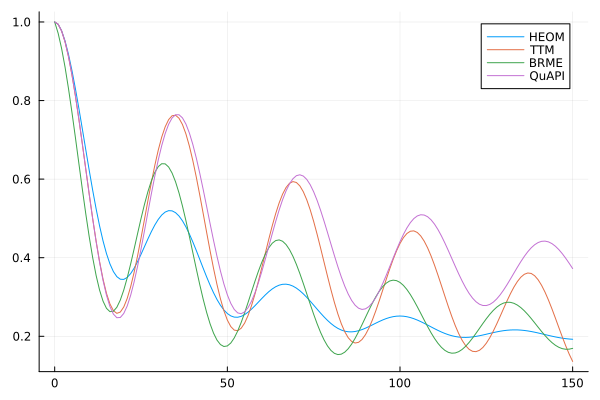

In [47]:
plot(t_HEOM.*au2fs, real.(ρs_HEOM[:,1,1]), label="HEOM")
plot!(t_TTM.*au2fs, real.(ρ_TTM[:,1,1]), label="TTM")
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,1,1]), label="BRME")
plot!(tq.*au2fs, real.(ρq[:,1,1]), label="QuAPI")

Same paper, 3 states "sequential" regime

In [79]:
ES = 250.0
ECT = 200.0
ETT = 0.0

VSCT = 3.0
VCTTT = 17

N = 3

H_seq = Matrix{ComplexF64}([
        ES VSCT 0.0
        VSCT ECT VCTTT
        0.0 VCTTT ETT
    ])*mev2au

λs = repeat([25.0], N) * mev2au
γs = repeat([150.0], N) * mev2au
JwH = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwH, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

dt = 1/au2fs 
nsteps = 14000
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1.0

β = 1 / (300 * 3.16683e-6) # T = 300K

@time t_HEOM, ρs_HEOM = HEOM.propagate(;
                                    Hamiltonian=H_seq,
                                    ρ0,
                                    β,
                                    dt,
                                    ntimes=nsteps,
                                    Jw=JwH,
                                    sys_ops=sys_ops,
                                    num_modes=2,
                                    Lmax=3)

279.992049 seconds (2.74 G allocations: 164.119 GiB, 9.10% gc time)


([0.0, 41.34137457575099, 82.68274915150198, 124.02412372725297, 165.36549830300396, 206.70687287875495, 248.04824745450594, 289.38962203025693, 330.7309966060079, 372.0723711817589  …  578448.5130639079, 578489.8544384836, 578531.1958130593, 578572.5371876351, 578613.8785622108, 578655.2199367866, 578696.5613113623, 578737.902685938, 578779.2440605138, 578779.2440605139], [1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.9999794648104872 + 0.0im 0.00015688454650337447 - 0.004469179013586259im -5.662608389621274e-5 - 8.44045636204892e-6im; … ; 0.015452093878066543 + 0.0im -0.0002730498037037007 - 0.00043842697958246745im 0.0007302011147380439 - 3.033967391150274e-5im; 0.015452093878066533 + 0.0im -0.000273049803703701 - 0.00043842697958246707im 0.0007302011147380439 - 3.0339673911502708e-5im;;; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.00015688454650337447 + 0.004469179013586259im 2.0531794194243705e-5 + 0.0im 2.9317862580251186e-8 - 2.6088086712336094e-7im; … ; -0.0002730498037037007 + 0.000438426

In [82]:
#=Jw = SpectralDensities.DrudeLorentz(λ=25*mev2au, γ=150*mev2au, Δs=1.0)
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H_seq, dt=dt, ntimes=nsteps)
@time t_TTM, ρ_TTM = TTM.propagate(; fbU=fbU,
                            Jw=[Jw],
                            β=β,
                            ρ0=ρ0,
                            dt=dt,
                            ntimes=nsteps,
                            rmax=10,
                            svec=[1.0 2.0 3.0],
                            extraargs=TEMPO.TEMPOArgs(),
                            path_integral_routine=TEMPO.build_augmented_propagator)=#

In [91]:
Jw = SpectralDensities.DrudeLorentz(; λ=25*mev2au, γ=150*mev2au, Δs=1.0)
ωs, cs = SpectralDensities.discretize(Jw, 20)
hb = Solvents.HarmonicBath(β, ωs, cs, [1.0, 2.0, 3.0], 1000)
@time tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw=Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=3, svec=[1.0 2.0 3.0], extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate, verbose=true)

[ Info: Starting propagation within memory
[ Info: Step = 1, #paths = 1
[ Info: Step = 2, #paths = 9
[ Info: Step = 3, #paths = 81
[ Info: Starting iteration
[ Info: Step = 4, #paths = 729
[ Info: Step = 5, #paths = 6561
[ Info: Step = 6, #paths = 6561
[ Info: Step = 7, #paths = 6561
[ Info: Step = 8, #paths = 6561
[ Info: Step = 9, #paths = 6561
[ Info: Step = 10, #paths = 6561
[ Info: Step = 11, #paths = 6561
[ Info: Step = 12, #paths = 6561
[ Info: Step = 13, #paths = 6561
[ Info: Step = 14, #paths = 6561
[ Info: Step = 15, #paths = 6561
[ Info: Step = 16, #paths = 6561
[ Info: Step = 17, #paths = 6561
[ Info: Step = 18, #paths = 6561
[ Info: Step = 19, #paths = 6561
[ Info: Step = 20, #paths = 6561
[ Info: Step = 21, #paths = 6561
[ Info: Step = 22, #paths = 6561
[ Info: Step = 23, #paths = 6561
[ Info: Step = 24, #paths = 6561
[ Info: Step = 25, #paths = 6561
[ Info: Step = 26, #paths = 6561
[ Info: Step = 27, #paths = 6561
[ Info: Step = 28, #paths = 6561
[ Info: Step = 29, #path

LoadError: InterruptException:

In [81]:
@time t_BRME, ρs_BRME = BlochRedfield.propagate(;
                                            Hamiltonian=H_seq,
                                            Jw=JwH,
                                            β,
                                            ρ0,
                                            dt,
                                            ntimes=nsteps,
                                            sys_ops)

  0.978853 seconds (27.51 M allocations: 1.003 GiB, 13.31% gc time)


([0.0, 41.34137457575099, 82.68274915150198, 124.02412372725297, 165.36549830300396, 206.70687287875495, 248.04824745450594, 289.38962203025693, 330.7309966060079, 372.0723711817589  …  578448.5130639079, 578489.8544384836, 578531.1958130593, 578572.5371876351, 578613.8785622108, 578655.2199367866, 578696.5613113623, 578737.902685938, 578779.2440605138, 578779.2440605139], [1.0000000000000002 + 0.0im -2.65442440322693e-20 + 0.0im 8.657359361334486e-19 + 0.0im; 0.9997797501589584 + 1.0842021724855044e-19im -0.004151405571293523 - 0.004709913413316118im -0.0002603115163939716 + 1.3869507510697437e-5im; … ; 0.0015041211377566806 - 8.893845946170154e-21im -0.0002805312545362681 - 4.7122973815130924e-5im 0.0009754853773895662 - 2.3936159933496617e-6im; 0.001504121137756679 - 8.893845946170154e-21im -0.0002805312545362678 - 4.712297381513087e-5im 0.0009754853773895662 - 2.3936159933496515e-6im;;; 2.0816681711721685e-17 + 0.0im 4.3133162925050917e-19 + 0.0im 5.2902225286959355e-20 + 0.0im; -0

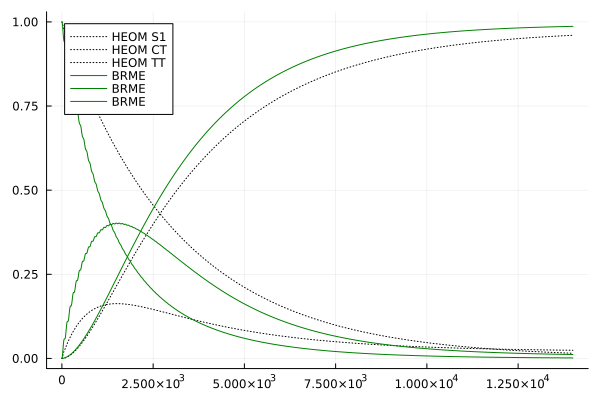

In [62]:
plot(t_HEOM.*au2fs, real.(ρs_HEOM[:,1,1]), label="HEOM S1", ls=:dot, lc=:black)
plot!(t_HEOM.*au2fs, real.(ρs_HEOM[:,2,2]), label="HEOM CT", ls=:dot, lc=:black)
plot!(t_HEOM.*au2fs, real.(ρs_HEOM[:,3,3]), label="HEOM TT", ls=:dot, lc=:black)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,1,1]), label="TTM", lc=:blue)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,2,2]), label="TTM", lc=:blue)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,3,3]), label="TTM", lc=:blue)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,1,1]), label="BRME", lc=:green)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,2,2]), label="BRME", lc=:green)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,3,3]), label="BRME", lc=:green)

Same paper, "superexchange" regime

In [92]:
ES = 80.0
ECT = 330.0
ETT = 0.0

VSCT = 30.0
VCTTT = 30.0

N = 3

H_sup = Matrix{ComplexF64}([
        ES VSCT 0.0
        VSCT ECT VCTTT
        0.0 VCTTT ETT
    ])*mev2au

λs = repeat([25.0], N) * mev2au
γs = repeat([150.0], N) * mev2au
JwH = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwH, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

dt = 1/au2fs 
nsteps = 1400
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1.0

β = 1 / (300 * 3.16683e-6) # T = 300K

@time t_HEOM, ρs_HEOM = HEOM.propagate(;
                                    Hamiltonian=H_sup,
                                    ρ0,
                                    β,
                                    dt,
                                    ntimes=nsteps,
                                    Jw=JwH,
                                    sys_ops=sys_ops,
                                    num_modes=3,
                                    Lmax=5)

LoadError: InterruptException:

In [93]:
#=Jw = SpectralDensities.DrudeLorentz(λ=25*mev2au, γ=150*mev2au, Δs=1.0)
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H_seq, dt=dt, ntimes=nsteps)
@time t_TTM, ρ_TTM = TTM.propagate(; fbU=fbU,
                            Jw=[Jw],
                            β=β,
                            ρ0=ρ0,
                            dt=dt,
                            ntimes=nsteps,
                            rmax=10,
                            svec=[1.0 2.0 3.0],
                            extraargs=TEMPO.TEMPOArgs(),
                            path_integral_routine=TEMPO.build_augmented_propagator)=#

In [94]:
@time t_BRME, ρs_BRME = BlochRedfield.propagate(;
                                            Hamiltonian=H_sup,
                                            Jw=JwH,
                                            β,
                                            ρ0,
                                            dt,
                                            ntimes=nsteps,
                                            sys_ops)

  0.606221 seconds (17.76 M allocations: 614.869 MiB, 15.37% gc time)


([0.0, 41.34137457575099, 82.68274915150198, 124.02412372725297, 165.36549830300396, 206.70687287875495, 248.04824745450594, 289.38962203025693, 330.7309966060079, 372.0723711817589  …  57505.852034869626, 57547.193409445375, 57588.534784021125, 57629.87615859688, 57671.21753317263, 57712.55890774838, 57753.90028232413, 57795.24165689988, 57836.58303147563, 57877.92440605139], [0.9999999999999997 + 0.0im -1.3776452278776043e-17 + 0.0im 7.005105271946897e-18 + 0.0im; 0.996704240378379 - 8.673617379884035e-19im -0.009484732675874404 - 0.044310868253106185im 0.006292054939670726 + 0.0005451268228682095im; … ; 0.12595944113762766 - 8.673617379884035e-19im -0.01445358629527947 + 0.004607258993039238im 0.02136754159611698 - 0.0005618591971006514im; 0.1262284817554184 - 3.7947076036992655e-19im -0.012997840878406473 + 0.0035483797751879446im 0.022278798760465606 - 0.000926578104465765im;;; 1.3877787807814457e-17 + 0.0im 1.5587579125167058e-18 + 0.0im 3.348816531123529e-20 + 0.0im; -0.00948473

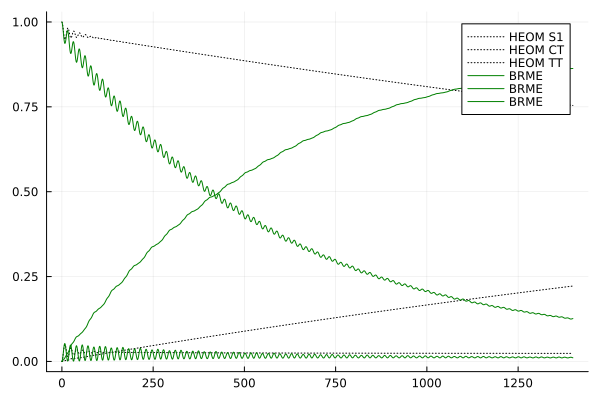

In [95]:
plot(t_HEOM.*au2fs, real.(ρs_HEOM[:,1,1]), label="HEOM S1", ls=:dot, lc=:black)
plot!(t_HEOM.*au2fs, real.(ρs_HEOM[:,2,2]), label="HEOM CT", ls=:dot, lc=:black)
plot!(t_HEOM.*au2fs, real.(ρs_HEOM[:,3,3]), label="HEOM TT", ls=:dot, lc=:black)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,1,1]), label="TTM", lc=:blue)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,2,2]), label="TTM", lc=:blue)
#plot!(t_TTM.*au2fs, real.(ρ_TTM[:,3,3]), label="TTM", lc=:blue)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,1,1]), label="BRME", lc=:green)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,2,2]), label="BRME", lc=:green)
plot!(t_BRME.*au2fs, real.(ρs_BRME[:,3,3]), label="BRME", lc=:green)

Pentacene dimer in second paper

In [ ]:
H0 = Matrix{ComplexF64}([
        ECA 116.0 -152.0 145.0 0.0
        116.0  ES1S0   0.0 0.0 145.0
        -152.0 0.0 ETT 0 133.0
        145.0 0.0 0 ES0S1 116.0
        0.0 145.0 133.0 116.0 EAC
    ]) * mev2au